In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "64" # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u


In [6]:
nside = 2048
lmax = 2048
 

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB"]

## using the planck 060 mask 

In [10]:
datadir='/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust/'

planck_mask =  hp.reorder(
    fits.open(datadir+"HFI_Mask_GalPlane-apo0_2048_R2.00.fits")[1].data["GAL060"], n2r=True)


In [11]:
planck_mask= np.int_( np.ma.masked_not_equal(planck_mask ,  0 ).mask )

In [12]:
fsky= planck_mask.sum()/planck_mask.size 

In [13]:
fsky 

0.600813110669454

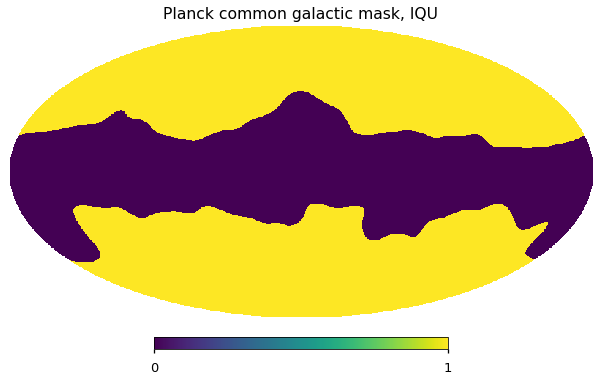

In [14]:
hp.mollview( (planck_mask), title=f"Planck common galactic mask, {comp}")

## Dust maps 
- We use the GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with variable resolutions 
- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with variable resolutions. 



In [15]:
dust_varresI = datadir+"COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits"
dust_varresP= datadir+"COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [16]:
m_planck_varres ,h = hp.read_map(dust_varresP , [c+"_STOKES" for c in comp], h=True)
I_planck_varres ,h = hp.read_map(dust_varresI , h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [17]:
m_planck_varres <<= u.K_CMB 
I_planck_varres <<= (u. MJy/u.sr ) 
m_planck_varres = m_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))
I_planck_varres = I_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz)) 

then we are ready to combine both maps into one single TQU map. 

In [18]:
m_planck_varres[0] = I_planck_varres.copy() 


In [19]:
m_planck_varres

<Quantity [[43.0273902 , 42.92068074, 43.06042748, ..., 45.21239639,
            44.92046335, 45.07314786],
           [ 0.06983504, -1.23525188,  0.05793881, ...,  0.0877997 ,
            -1.41070242,  0.10831319],
           [-0.15870707,  0.26476554, -0.15045897, ..., -0.79859751,
             1.02944243, -0.80487465]] uK_RJ>

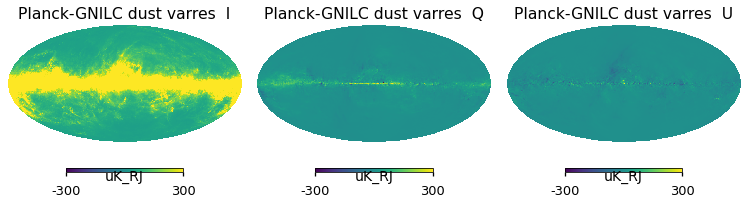

In [20]:
for i_pol, pol in components:
    hp.mollview(m_planck_varres[i_pol], title="Planck-GNILC dust varres  "+pol , sub=131+i_pol  , unit=m_planck_varres.unit, min=-300, max=300)
    
    

## Monopole subtraction  

we   estimate the monopole term from the map outside the galactic mask to have a rough estimate of the CIB monopole .


However, we don't perform the monopole subtraction now but  will be  performed at the end of the small scale injection . 

Infact, we noticed that:
- doing it before transforming to logarithmic pol. tensor results in NaN regions in correspondence of $I^2 - P^2 < 0 $ pixels  
- removing a monopole term in the pol.tensor transformed quantity $i,q,u$ is not correct as  when we transform back to real quantities the maps before and after transformation don't match . 
E.g. 
assume you subtract a constant term to $i$ , i.e. 
$$i' =i -c$$
then 
$$I'\neq I$$
since 
$$ I' = e^{i'} \cosh p  = e^{i-c}\cosh p  = e^{-c} I $$.  

In [21]:
mono, dip_vector = hp.fit_dipole(m_planck_varres[0][planck_mask])

In [22]:
print(" the estimated monopole is ",(mono  *u.uK_RJ).to("MJy/sr", equivalencies=u.cmb_equivalencies(353*u.GHz))  )

 the estimated monopole is  0.1644821183049364 MJy / sr


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

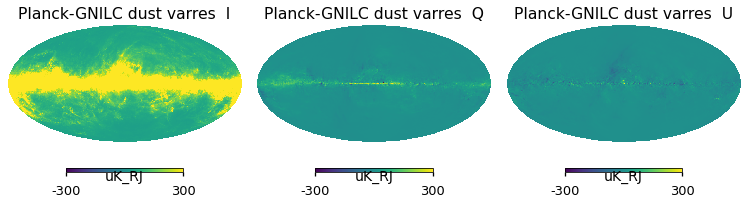

In [23]:
for i_pol, pol in components:
    hp.mollview(m_planck_varres[i_pol], title="Planck-GNILC dust varres  "+pol , sub=131+i_pol  , unit=m_planck_varres.unit, min=-300, max=300)
    
    

## Transform maps to Poltens quantities 

In [21]:
import numpy as np
import healpy as hp



def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i =np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))
    # return np.heaviside(x - x0, 0)
    #fwhm = 20 * u.arcmin
    #return 1 - hp.gauss_beam(fwhm=fwhm.to_value(u.radian), lmax=x[-1])**2

In [22]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres .value)

<ipython-input-21-18e0cc75e7ff>:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
<ipython-input-21-18e0cc75e7ff>:10: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


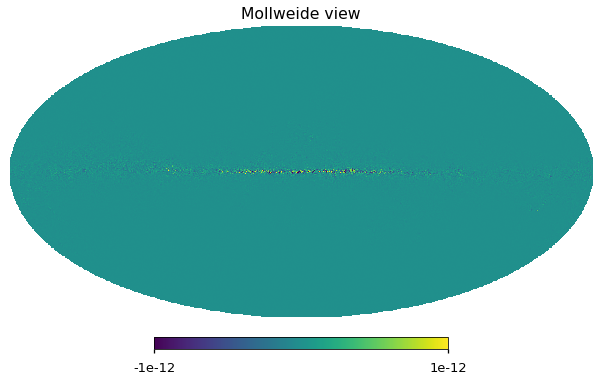

In [28]:
m_back   = log_pol_tens_to_map(log_pol_tens_varres ) 
hp.mollview( (m_planck_varres.value  - m_back )[1], min=-1e-12,max=1e-12 )

In [29]:
del m_back 

In [23]:
assert np.isnan(log_pol_tens_varres).sum() == 0

AssertionError: 

In [24]:
for i in range(3):
    log_pol_tens_varres [i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(log_pol_tens_varres[i])

In [25]:
assert np.isnan(log_pol_tens_varres).sum() == 0

In [26]:
log_pol_tens_varres = hp.ma(log_pol_tens_varres)
log_pol_tens_varres.mask = planck_mask==0

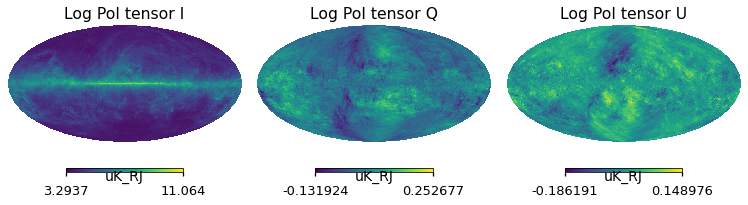

In [27]:
for i_pol, pol in components:
    hp.mollview(log_pol_tens_varres[i_pol].data, title="Log Pol tensor "+pol , sub=131+i_pol  , unit=m_planck_varres.unit)
    
    

In [28]:
from scipy.optimize import curve_fit

In [29]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [41]:
def run_anafast(m, lmax) : 
    clanaf=hp.anafast(m , lmax=lmax ) 
    cl ={} 
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2 ]
    ell = np.arange(lmax +1 ) 
    
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell,cl_norm, cl     


## We perform this analysis on fullsky maps (no spectra estimated with Namaster on partial sky  ) 
the reason is mainly due to the fact that  the map with large  scales `LS` is estimated  by running alm2map on low pass filtered alm  . When we combine `LS` with  the small scales map `SS`,  obtained by extrapolating the  namaster spectra,  
 as
`m = LS +SS ` 
we find a mismatch in the part where the two spectra join. 

An alternative might be to run everything with anafast full sky, and  the solution match pretty well . 

In [39]:
ell, cl_norm, cl =run_anafast(m=log_pol_tens_varres.data , lmax =lmax ) 

In [75]:
fspectra=datadir+"cl_dust_gnilc_logpoltens_varres2.npz"
ell =np.load(fspectra)['ell']
cl_norm =np.load(fspectra)['cl_norm']
cl ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 

<ipython-input-76-512da9df0fd2>:30: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)
<ipython-input-76-512da9df0fd2>:33: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e1 if pol == "TT" else 1e-3)
<ipython-input-76-512da9df0fd2>:30: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)
<ipython-input-76-512da9df0fd2>:33: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e1 if pol == "TT" else 1e-3)
<ipython-input-76-512da9df0fd2>:30: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)
<ipython-input-76-512da9df0fd2>:33: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ign

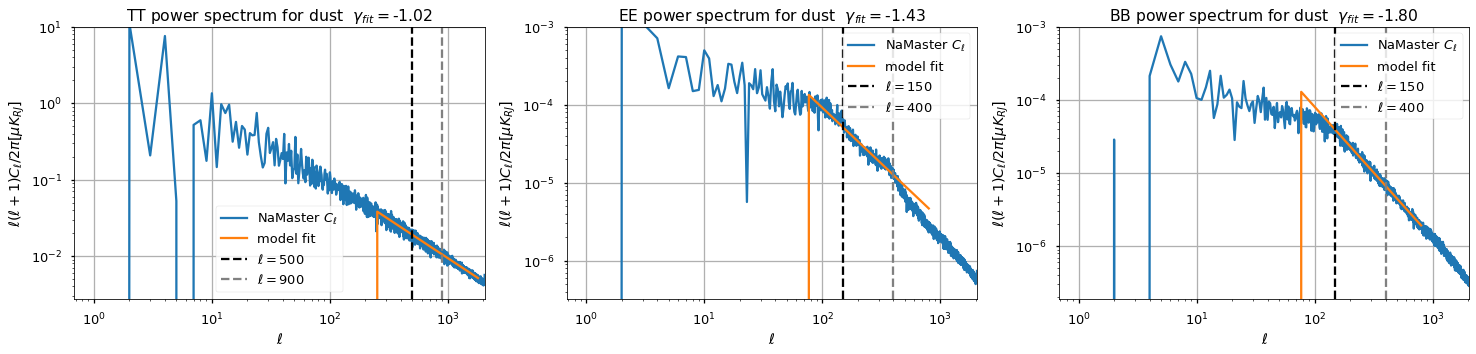

In [76]:
ell_fit_low = {"TT":500, "EE":150, "BB":150}
ell_fit_high = {"TT":900, "EE":400, "BB":400}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    # plt.semilogx(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell smoothed$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="model fit")
    
    #plt.plot(w_ell**2,  label=f"Beam {c} $C_\ell$")

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(0, lmax)
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2, lmax)
    plt.ylim(0, 1e1 if pol == "TT" else 1e-3)


## making   Gaussian small scales   

In [32]:
np.random.seed(777)
zeros = np.zeros(len(ell), dtype=np.double)


In [108]:
ell

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.046e+03, 2.047e+03,
       2.048e+03])

In [33]:
small_scales_input_cl = [
    1 \
    * model(ell, A_fit[pol], gamma_fit[pol]) \
    * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10)  \
    / cl_norm \
    for pol in spectra_components
]

<ipython-input-29-e2b761b15d12>:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [34]:
m_sigma_G = hp.synfast(small_scales_input_cl + [zeros, zeros, zeros], nside, new=True)

### filtering large scales 

In [57]:
alm_log_pol_tens_fullsky = hp.map2alm(log_pol_tens_varres  , lmax=lmax, use_pixel_weights=True)
alm_log_pol_tens_fullsky1 = hp.map2alm(log_pol_tens_varres.data  , lmax=lmax, use_pixel_weights=True)

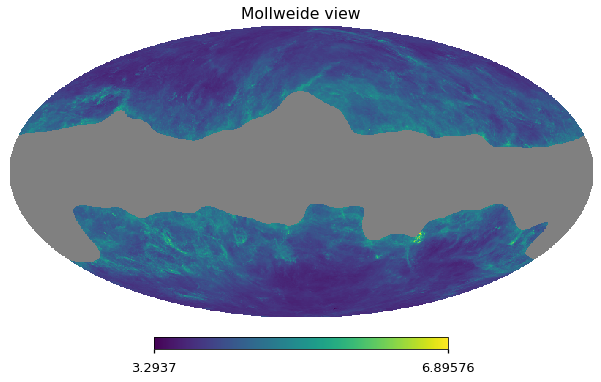

In [124]:
hp.mollview(log_pol_tens_varres[0] ) 

In [58]:
pol="TT"
hp.almxfl(alm_log_pol_tens_fullsky1[0],np.sqrt(1-sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/40)), inplace=True)

array([17.23051026+0.j, -0.08789376+0.j, -2.65382782+0.j, ...,
       -0.        +0.j,  0.        +0.j, -0.        +0.j])

In [59]:
pol = "EE"
sigmoid_pol = np.sqrt(1-sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10))
for i in [1,2]:
    hp.almxfl(alm_log_pol_tens_fullsky1[i], sigmoid_pol, inplace=True)
    

In [60]:
log_pol_tens_largescales = hp.alm2map(alm_log_pol_tens_fullsky1, nside=nside)

In [64]:
clLS = hp.alm2cl(alms1=alm_log_pol_tens_fullsky1,  )

## making a map with large scale only 

In [87]:
log_pol_tens_largescales = hp.alm2map(alm_log_pol_tens_fullsky, nside=nside)

In [68]:
hp.write_map (datadir+'dust_gnilc_logpoltens_varres2_largescales_test.fits',log_pol_tens_largescales, overwrite=True )

## combine Large scale maps with     small scale ones   (uniformly distributed ) 

In [39]:
output_log_pol_tens_map = log_pol_tens_largescales + m_sigma_G

In [137]:
hp.write_map (datadir+'dust_gnilc_logpoltens_varres2_combined_fullsky_test.fits', output_log_pol_tens_map)

In [42]:
ell, cl_norm, clLS =run_anafast(m=log_pol_tens_largescales , lmax =lmax ) 

In [43]:

ell, cl_norm, clcomb  =run_anafast(m=output_log_pol_tens_map , lmax =lmax ) 

In [73]:
fspectra=datadir+"cl_dust_gnilc_logpoltens_varres2_largescales_test.npz"
ell =np.load(fspectra)['ell']
cl_norm =np.load(fspectra)['cl_norm']
clLSn ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
fspectra=datadir+"cl_dust_gnilc_logpoltens_varres2_combined_fullsky.npz"
ell =np.load(fspectra)['ell']
cl_norm =np.load(fspectra)['cl_norm']
clcombn ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 

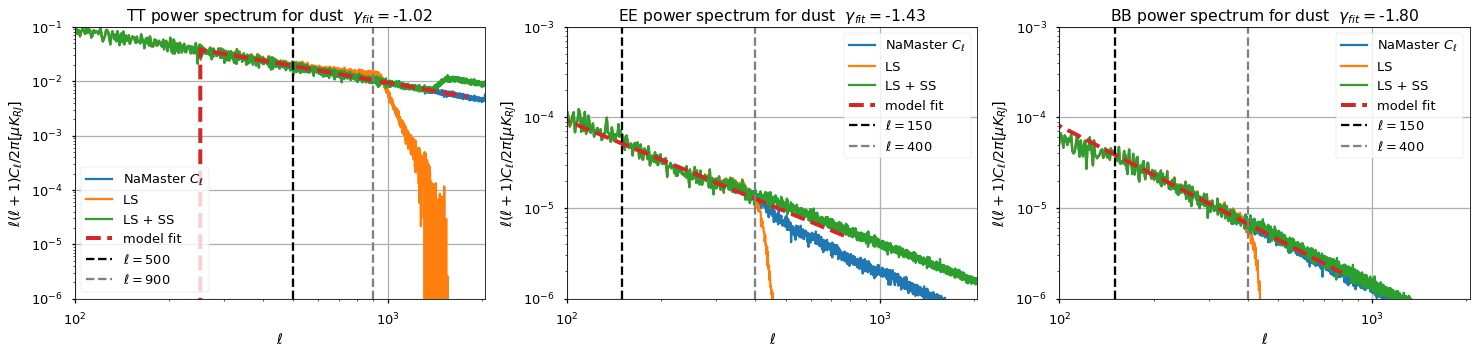

In [74]:
ell_fit_low = {"TT":500, "EE":150, "BB":150}
ell_fit_high = {"TT":900, "EE":400, "BB":400}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    
    # plt.semilogx(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell smoothed$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clLSn  [pol]  ,label='LS ')
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clcombn  [pol],label='LS + SS ')
    
    #plt.plot(ell, ell*(ell+1)/np.pi/2 * clLS  [ii]  ,label='LS ')
    #plt.plot(ell, ell*(ell+1)/np.pi/2 * clcomb  [pol]  ,label='LS ')
    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]),lw=4,linestyle='--',  
             label="model fit")
    #plt.plot(w_ell**2,  label=f"Beam {c} $C_\ell$")

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(100,lmax)
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2 +10 , lmax)
    plt.ylim(1e-6, 1e-1 if pol == "TT" else 1e-3)


In [47]:
output_map = log_pol_tens_to_map(output_log_pol_tens_map) 

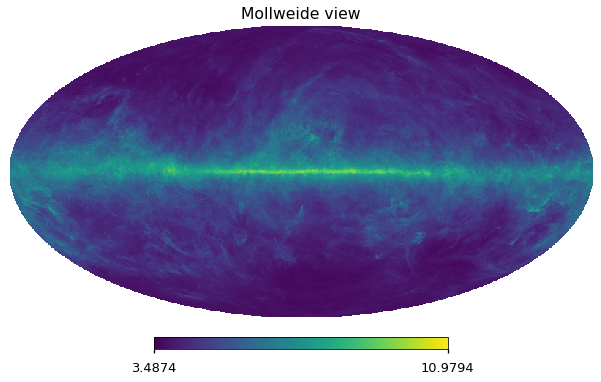

In [48]:
hp.mollview(log_pol_tens_largescales [0] )

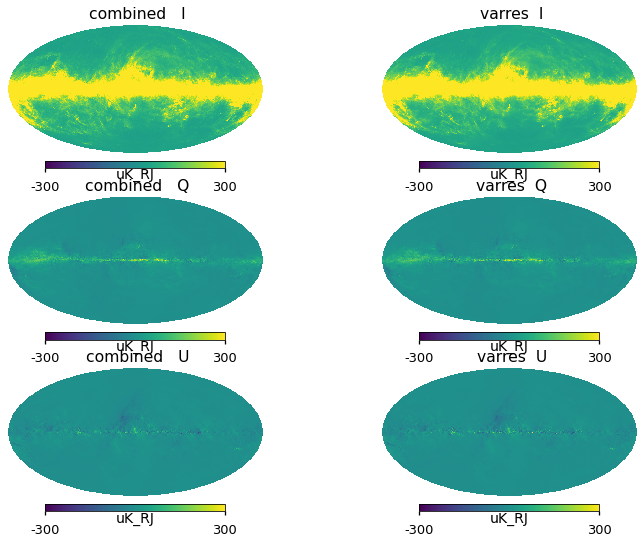

In [49]:
for i_pol, pol in components:
    hp.mollview(output_map [i_pol], title=" combined   "+pol , sub=321+(2*i_pol) , unit=m_planck_varres.unit, min=-300, max=300)    
    hp.mollview(m_planck_varres[i_pol], title=" varres  "+pol , sub=321+(2*i_pol+1) , unit=m_planck_varres.unit, min=-300, max=300)

In [50]:
cl_in = hp.anafast(m_planck_varres ,lmax=lmax)

In [51]:
cl_out = hp.anafast(output_map,lmax=lmax)

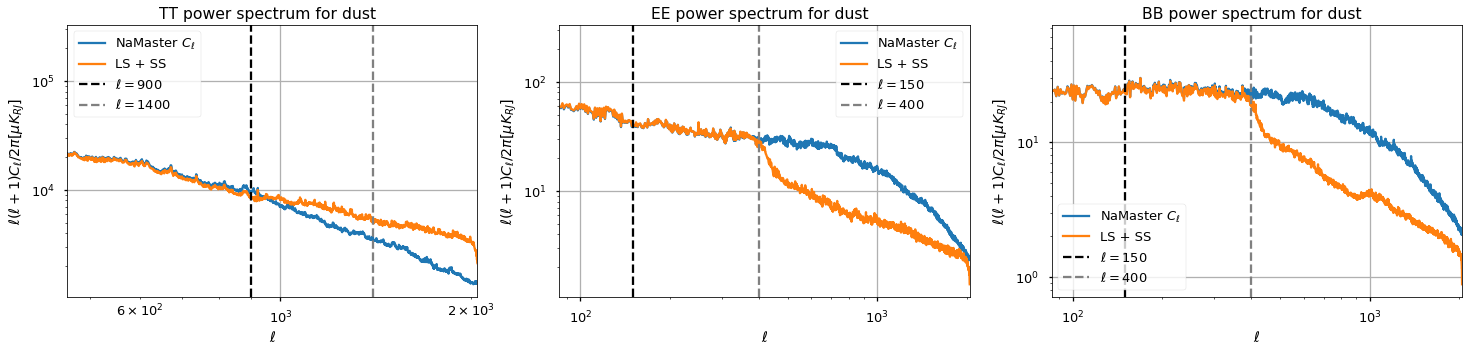

In [52]:
ell_fit_low = {"TT":900, "EE":150, "BB":150}
ell_fit_high = {"TT":1400, "EE":400, "BB":400}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_in[ii], label="NaMaster $C_\ell$")

    plt.plot(ell, ell*(ell+1)/np.pi/2 * cl_out  [ii],label='LS + SS ')

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  " )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.xlim(100,1000)
    #plt.ylim(1, 30);
    plt.xlim(ell_fit_low[pol]//2 +10 , lmax)
    #plt.ylim(1e-6, 1e-2 if pol == "TT" else 1e-3)

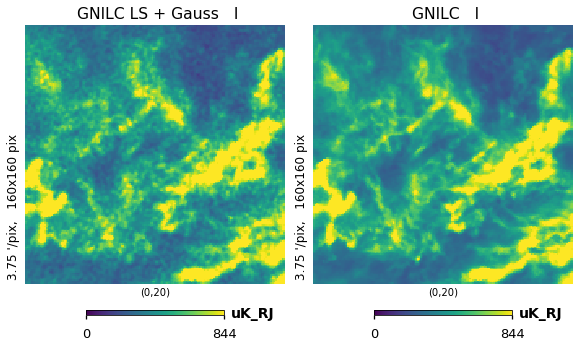

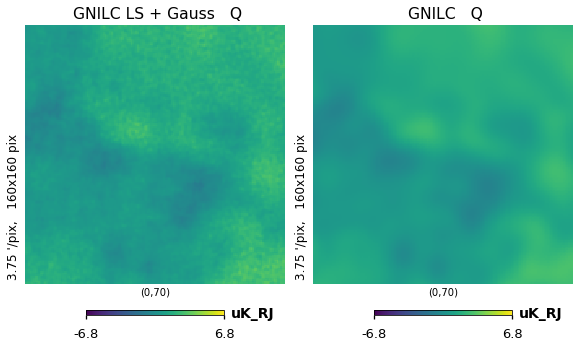

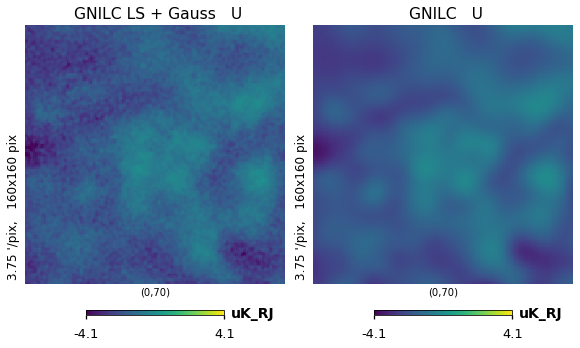

In [53]:
for i_pol, pol in components:
    plt.figure(figsize=(8,15))
    if i_pol==0:
        rot=[0,20]
        mmin =0 ; mmax= m_planck_varres[i_pol].value.std() 
    else: 
        rot=[0,70]
        mmin=-m_planck_varres[i_pol].value.std()/3; mmax=m_planck_varres[i_pol].value.std()/3
    hp.gnomview(output_map [i_pol], title=" GNILC LS + Gauss   "+pol ,rot=rot, sub=321+(2*i_pol) ,reso=3.75,xsize=160, unit=m_planck_varres.unit,
                    min=mmin, max=mmax)  
                
    hp.gnomview(m_planck_varres[i_pol], title=" GNILC   "+pol ,rot=rot,  sub=321+(2*i_pol+1),reso=3.75,xsize=160, unit=m_planck_varres.unit,
                    min=mmin, max=mmax)
               


In [134]:
fspectra=datadir+"cl_dust_map_gnilc_planck_varres_release2and3_gaussianSS.npz"
ell =np.load(fspectra)['ell']
cl_norm =np.load(fspectra)['cl_norm']
cl_out  ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 

fspectra=datadir+"cl_dust_map_gnilc_planck_varres_release2and3.npz"
ell =np.load(fspectra)['ell']
cl_norm =np.load(fspectra)['cl_norm']
cl_in  ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 

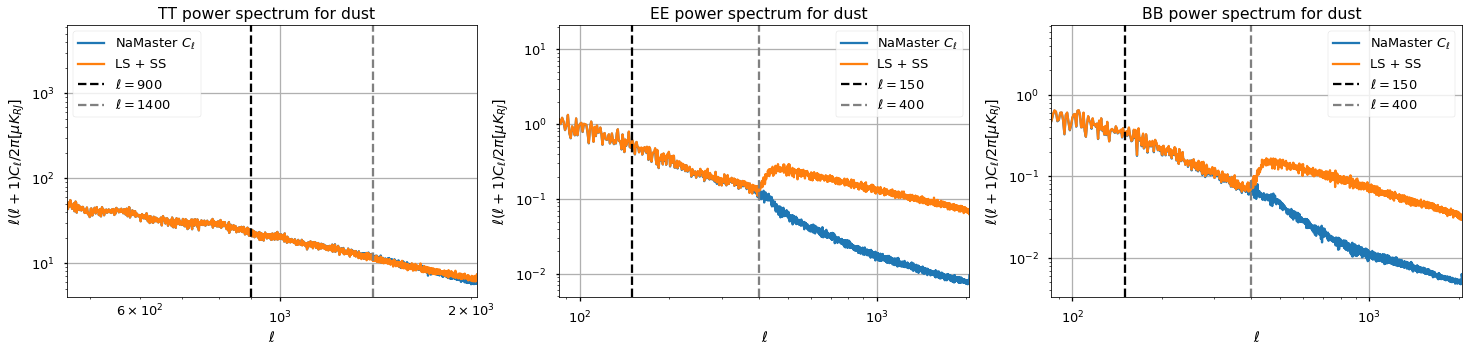

In [135]:
ell_fit_low = {"TT":900, "EE":150, "BB":150}
ell_fit_high = {"TT":1400, "EE":400, "BB":400}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_in[pol], label="NaMaster $C_\ell$")

    plt.plot(ell, ell*(ell+1)/np.pi/2 * cl_out  [pol],label='LS + SS ')

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  " )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.xlim(100,1000)
    #plt.ylim(1, 30);
    plt.xlim(ell_fit_low[pol]//2 +10 , lmax)
    #plt.ylim(1e-6, 1e-2 if pol == "TT" else 1e-3)